In [1]:
import sys

sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import io
import os
import pickle
from pathlib import Path
import pandas as pd
import torch
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import shutil

from importlib import reload

from utils import calc_num_params

In [4]:
def get_last_in_path(path):
    return str(path).split('/')[-1]

In [5]:
run_project_name = 'num_params_relation' # change accordingly
log_path = f'../num_params_logs/{run_project_name}'
results_path = '../num_params_logs/results'
images_path = '../num_params_logs/images'

In [127]:
run_project_name = 'test_name' # change accordingly
log_path = f'../../Scratch/merged-data/{run_project_name}'
results_path = '../../Scratch/merged-data/results'
images_path = '../../Scratch/merged-data/images'

# Collect data into DataFrame

In [6]:
from collections import defaultdict
d = []
check_list = defaultdict(list)


# Adapted from https://github.com/nik-sm/generator-surgery/blob/master/utils.py#L160 
# because our folder structure is modelled after theirs
for model_path in Path(results_path).iterdir():
    model = get_last_in_path(model_path)
    #print("model:", model)
    for dataset_path in model_path.iterdir():
        dataset = get_last_in_path(dataset_path)
        #print("dataset:", dataset)
        for img_path in dataset_path.iterdir():
            image = get_last_in_path(img_path)
            #print("image:", image)
            for fm_path in img_path.iterdir():
                forward_model = get_last_in_path(fm_path)
                #print("fm:", forward_model)
                for run_path in fm_path.iterdir():
                    run_params = get_last_in_path(run_path)
                    #print("run:", run_params)
                    if '^' in str(run_path):
                        # delete 
                        try:
                            new_path = str(run_path).replace("^", ".")
                            # print("moving to ", new_path)
                            # os.makedirs(new_path, exist_ok=True)
                            
                            for sub_dir in os.listdir(run_path):
                                dir_to_move = os.path.join(run_path, sub_dir)
                                print(f'Moving {dir_to_move} to {new_path}')
                                # shutil.move(dir_to_move, new_path)
                            
                            # shutil.rmtree(run_path)
                            print("Removed: \n", run_path)
                        except OSError as e:
                            print ("Error: %s - %s." % (e.filename, e.strerror))
                        
                    for cut_path in run_path.iterdir():
                        cut = get_last_in_path(cut_path).split('=')[-1]
                        cut_split = cut[1:-1].split(',')
                        first_cut = int(cut_split[0])
                        second_cut = int(cut_split[1])
                        is_valid=1
                        #print("cut:", cut)
                        try: 
                            with open(cut_path / 'metrics.pkl', 'rb') as f:
                                metrics = pickle.load(f)
                            
                            recovered_img = torch.load(cut_path / 'recovered.pt', map_location=torch.device('cpu'))
                        except FileNotFoundError as err:
                            print('Could not find metrics.pkl from ', cut_path)
                            continue
                            
                        if metrics['TRAIN_MSE'] > 0.01:
                            # for a valid run, train_mse shouldn't be greater than 0.01
                            check_list[cut].append((image, recovered_img))
                            is_valid=0
                            # check the recovered_img

                        
                        run_params_split = filter(lambda s : '=' in s, run_params.split('.'))
                        run_params_split = map(lambda x: x.split('=')[1], run_params_split)
                        tv_weight, cos_weight, opt, n_steps, z_lr, restarts, z_number = run_params_split
                        tv_weight = float(tv_weight)
                        cos_weight = float(cos_weight)
                        n_steps = int(n_steps)
                        z_lr = float(z_lr)
                        restarts = int(restarts)
                        z_number = int(z_number)
                        
                        row = {
                            'model': model,
                            'dataset': dataset,
                            'image': image,
                            'fm': forward_model,
                            'run': run_params,
                            'tv_weight': tv_weight,
                            'cos_weight': cos_weight,
                            'opt': opt,
                            'n_steps': n_steps,
                            'z_lr': z_lr,
                            'restarts': restarts,
                            'z_number': z_number,
                            'cut':cut,
                            'first_cut': first_cut,
                            'second_cut': second_cut,
                            'is_valid': is_valid,
                            **metrics
                        }
                        d.append(row)

                        
results_df = pd.DataFrame(d)

Could not find metrics.pkl from  ../num_params_logs/results/began/test2017/000000018900/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=500/cuts=[0, 12]
Could not find metrics.pkl from  ../num_params_logs/results/began/test2017/000000018900/InpaintingScatter.fraction_kept=0.1/tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs.n_steps=30.z_lr=1.0.restarts=3.z_number=800/cuts=[0, 12]


In [7]:
all_cuts = results_df['cut'].unique()

In [9]:
for c in all_cuts:
    num_succeed = len(results_df[results_df['cut'] == c])
    if num_succeed == 0:
        print(f'==> ERROR: {c} has no runs!')
    else:
        print(f'==> Results for {c} had {num_succeed} runs and {len(check_list[c])} invalid run')

==> Results for [0, 12] had 24 runs and 0 invalid run
==> Results for [0, 8] had 32 runs and 0 invalid run
==> Results for [2, 15] had 16 runs and 0 invalid run
==> Results for [2, -1] had 4 runs and 0 invalid run
==> Results for [8, -1] had 4 runs and 0 invalid run
==> Results for [11, -1] had 4 runs and 2 invalid run
==> Results for [5, -1] had 4 runs and 0 invalid run
==> Results for [0, 11] had 4 runs and 1 invalid run
==> Results for [0, 5] had 4 runs and 0 invalid run
==> Results for [11, 15] had 4 runs and 0 invalid run
==> Results for [5, 15] had 4 runs and 0 invalid run
==> Results for [8, 15] had 4 runs and 0 invalid run
==> Results for [0, 2] had 4 runs and 0 invalid run


# Record failure logs?

In [10]:
invalid_runs = dict()

for p in Path(log_path).iterdir():
    file_name = get_last_in_path(p)
    if not file_name.endswith('.txt'): 
        continue
    run_params = file_name[:-4] # abc.txt -> this removes .txt 
    cut = run_params.split('_')[-2].split('.')[-1].split('=')[1]
    
    # check if valid runs even exist:
    first_cut = int(cut.split(',')[0])
    num_succeed = len(results_df[(results_df['first_cut'] == first_cut)])
    if num_succeed == 0:
        invalid_runs[cut] = None
        continue
        
    with open(p, 'r') as f:
        lines = f.readlines()
        invalid_runs[cut] = set()
        if len(lines) > 0:
            # potentially invalid run for this particular run, store all the images which might be potentially invalid
            for line in lines:
                img_name = line.split('  ')[-2].split('.')[0]
                invalid_runs[cut].add(img_name)

In [11]:
import pprint

pprint.pprint({k: (-1 if v is None else len(v)) for k,v in invalid_runs.items()})

{'0,11': 1,
 '0,12': 0,
 '0,2': 0,
 '0,5': 0,
 '0,8': 0,
 '11,-1': 2,
 '11,15': 0,
 '2,-1': 0,
 '2,15': 0,
 '5,-1': 0,
 '5,15': 0,
 '8,-1': 0,
 '8,15': 0}


# Show failures

In [12]:
def show_failures(cut):
    failures = check_list['[' + cut + ']'].copy()
    num_failures = len(failures)
    
    print(f'Testing {cut}')
    print('Num failures: ', num_failures)

    nrows = max(1, math.ceil(num_failures / 4))
    ncols = math.ceil(num_failures / nrows)

    if ncols == 0:
        print('No failures')
        return

    print(f'Rows: {nrows}\tCols:{ncols}')
    
        
    # Also print a list of invalid image names
    print(list(map(lambda x: x[0], failures)))
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,9))
    fig.tight_layout()

    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx == num_failures:
                break
            # print(f'row:{row}\tcol:{col}\tidx:{idx}')
            img_name = failures[idx][0]
            
            img = failures[idx][1] 
            if nrows == 1 and ncols == 1:
                ax.set_title(img_name)
                ax.imshow(img.permute(1,2,0))
            elif nrows == 1 or ncols == 1:
                ax[idx].set_title(img_name)
                ax[idx].imshow(img.permute(1,2,0))
            else:
                ax[row][col].set_title(img_name)
                ax[row][col].imshow(img.permute(1,2,0))
    
    plt.show()

In [13]:
check_cut = '10, -1' # change accordingly

In [14]:
show_failures(check_cut)

Testing 10, -1
Num failures:  0
No failures


# Remove some runs from results_df

In [104]:
def remove_image_from_df(df, img_names):
    orig_len = len(df)
    for img_name in img_names:
        df = df[df['image'] != img_name] # remove all rows where image is == img_name
    after_len = len(df)
    print(f'Removed {after_len - orig_len} rows')
    return df

In [135]:
img_to_remove = ['ILSVRC2012_val_00041972', 'ILSVRC2012_val_00012614']

In [97]:
img_to_remove = [
    'ILSVRC2012_val_00041972', 'ILSVRC2012_val_00012614', 
    'ILSVRC2012_val_00046284', 'ILSVRC2012_val_00000440',
    'ILSVRC2012_val_00048004', 'ILSVRC2012_val_00015787', 
    'ILSVRC2012_val_00037863', 'ILSVRC2012_val_00042458'
]

In [136]:
results_df = remove_image_from_df(results_df, img_to_remove)

Removed -32 rows


### Remove cuts which are bad

In [15]:
to_remove_cuts = [(11,-1), (0,11)]

# remove cuts 11,-1 to 15,-1 as these are degenerate configurations
# to_remove_cuts = [(9, -1), (10, -1), (11,-1), (12,-1), (13,-1), (14,-1), (15,-1)]

In [16]:
def remove_cuts(df, remove_cuts):
    orig_len = len(df)
    for first_cut, second_cut in to_remove_cuts:
        mask = ~((df['first_cut'] == first_cut) & (df['second_cut'] == second_cut))
        df = df[mask]
    after_len = len(df)
    print(f'Removed {after_len - orig_len} rows')
    return df

In [17]:
results_df = remove_cuts(results_df, to_remove_cuts)

Removed -8 rows


In [18]:
print('Final number of rows: ', len(results_df))

Final number of rows:  104


# Verify successes are legit

### Here we should do a quick visualisation of all the images generated by a particular image (~30) to ensure that there are no outliers

In [19]:
def load_img_from_run_params(model, dataset, image, fm, run, cut):
    # returns pytorch tensor (C, H, W) representing the recovered image for the particular params
    # if doesn't exist, it raises a not found exception
    recovered_img_path = Path(results_path, model, dataset, image, fm, run, f'cuts={cut}') / 'recovered.pt'
    recovered_img = torch.load(recovered_img_path, map_location = torch.device('cpu'))
    return recovered_img

In [20]:
def visualize_gen_imgs(df, first_cut, second_cut):
    # generater plots showing all images generated by this cut on the particular dataset
    cut_df = df[(df['first_cut'] == first_cut) & (df['second_cut'] == second_cut)]
    imgs = cut_df['image']
    print(f'There are: {len(imgs)} images')
    ncols = 10 
    nrows = math.ceil(len(imgs) / ncols)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
    # fig.tight_layout()
    max_c_del = None
    max_r_del = None

    
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            if idx == len(imgs):
                max_c_del = col
                max_r_del = row
                break
            entry = cut_df.iloc[idx]
            recovered_img = load_img_from_run_params(
                model = entry['model'],
                dataset = entry['dataset'],
                image = entry['image'],
                fm = entry['fm'],
                run = entry['run'],
                cut = entry['cut']
            )
            if nrows > 1:
                ax[row][col].axis('off')
                ax[row][col].imshow( recovered_img.permute(1,2,0) )
            else:
                ax[col].axis('off')
                ax[col].imshow( recovered_img.permute(1,2,0) )
    
    if max_c_del is not None and max_r_del is not None:
        for r_del in range(max_r_del, nrows):
            for c_del in range(max_c_del, ncols):
                if nrows > 1:
                    fig.delaxes(ax[r_del,c_del])
                else:
                    fig.delaxes(ax[c_del])
        
    plt.subplots_adjust(wspace=0, hspace=0)
    
    

In [41]:
first_cut, second_cut = 0, 12

There are: 24 images


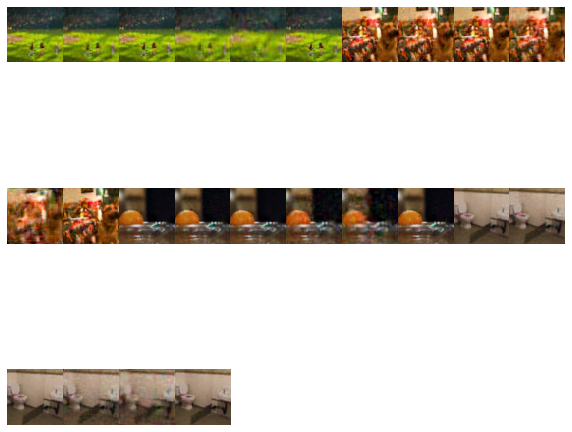

In [42]:
visualize_gen_imgs(results_df, first_cut, second_cut)

# Analyze results

In [26]:
prefilter_results_df = results_df
df = prefilter_results_df

### Filter out some results by criterion here

In [179]:
condition = (prefilter_results_df['z_number'] == 20) | (prefilter_results_df['second_cut'] == -1)

In [180]:
df = prefilter_results_df[condition]

In [181]:
df.head(3)

,model,dataset,image,fm,run,tv_weight,cos_weight,opt,n_steps,z_lr,...,cut,first_cut,second_cut,is_valid,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken
2,began,test2017,000000421458,InpaintingScatter.fraction_kept=0.1,tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs...,1.000000e-08,0.0,lbfgs,30,1.0,...,"[2, -1]",2,-1,1,0.000215,0.007053,21.516212,0.489573,0.492491,71.253719
3,began,test2017,000000421458,InpaintingScatter.fraction_kept=0.1,tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs...,1.000000e-08,0.0,lbfgs,30,1.0,...,"[8, -1]",8,-1,1,0.000034,0.015746,18.028162,0.546708,0.411395,5.068509
5,began,test2017,000000421458,InpaintingScatter.fraction_kept=0.1,tv_weight=1e-08.cos_weight=0.0.optimizer=lbfgs...,1.000000e-08,0.0,lbfgs,30,1.0,...,"[5, -1]",5,-1,1,0.000035,0.007706,21.131460,0.436329,0.532033,12.185397


In [182]:
len(df)

40

### Then group them

In [27]:
metrics = ['TRAIN_MSE', 'ORIG_MSE', 'ORIG_PSNR', 'ORIG_LPIPS', 'ORIG_SSIM', 'time_taken']

In [28]:
counts = df.groupby('cut').size().to_frame(name='counts')

In [29]:
# Rank cuts by PSNR 
df.groupby('cut').mean()[metrics].sort_values(by='ORIG_PSNR', ascending=False).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[5, 15]",1.085598e-06,0.002219,28.108897,0.164394,0.842764,92.430790,4
"[2, 15]",8.511157e-06,0.002817,27.356095,0.165113,0.808139,122.334798,16
"[8, 15]",8.229357e-07,0.002498,27.211602,0.199635,0.816431,116.716575,4
"[11, 15]",8.142799e-07,0.002882,26.699534,0.207572,0.791086,77.244908,4
"[0, 5]",1.030961e-04,0.003425,26.178403,0.254460,0.740061,68.442739,4
"[0, 8]",1.481800e-04,0.004033,25.654510,0.287245,0.708203,139.564585,32
"[0, 12]",1.771991e-04,0.004201,25.414266,0.329831,0.688820,123.627855,24
"[2, -1]",1.269001e-04,0.004481,25.186025,0.292721,0.706959,55.550923,4
"[0, 2]",1.803224e-04,0.004165,25.126214,0.302812,0.694644,56.940833,4


In [30]:
df.groupby('cut').mean()[metrics].sort_values(by='ORIG_LPIPS', ascending=True).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[5, 15]",1.085598e-06,0.002219,28.108897,0.164394,0.842764,92.430790,4
"[2, 15]",8.511157e-06,0.002817,27.356095,0.165113,0.808139,122.334798,16
"[8, 15]",8.229357e-07,0.002498,27.211602,0.199635,0.816431,116.716575,4
"[11, 15]",8.142799e-07,0.002882,26.699534,0.207572,0.791086,77.244908,4
"[0, 5]",1.030961e-04,0.003425,26.178403,0.254460,0.740061,68.442739,4
"[5, -1]",3.378869e-05,0.004678,24.688249,0.281496,0.721559,12.511994,4
"[0, 8]",1.481800e-04,0.004033,25.654510,0.287245,0.708203,139.564585,32
"[2, -1]",1.269001e-04,0.004481,25.186025,0.292721,0.706959,55.550923,4
"[0, 2]",1.803224e-04,0.004165,25.126214,0.302812,0.694644,56.940833,4


In [31]:
df.groupby('cut').mean()[metrics].sort_values(by='ORIG_SSIM', ascending=False).join(counts)

,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,counts
cut,,,,,,,
"[5, 15]",1.085598e-06,0.002219,28.108897,0.164394,0.842764,92.430790,4
"[8, 15]",8.229357e-07,0.002498,27.211602,0.199635,0.816431,116.716575,4
"[2, 15]",8.511157e-06,0.002817,27.356095,0.165113,0.808139,122.334798,16
"[11, 15]",8.142799e-07,0.002882,26.699534,0.207572,0.791086,77.244908,4
"[0, 5]",1.030961e-04,0.003425,26.178403,0.254460,0.740061,68.442739,4
"[5, -1]",3.378869e-05,0.004678,24.688249,0.281496,0.721559,12.511994,4
"[0, 8]",1.481800e-04,0.004033,25.654510,0.287245,0.708203,139.564585,32
"[2, -1]",1.269001e-04,0.004481,25.186025,0.292721,0.706959,55.550923,4
"[0, 2]",1.803224e-04,0.004165,25.126214,0.302812,0.694644,56.940833,4


# (Optional Section)

### Generate Graph of number of params vs performance in terms of ORIG_PSNR

In [32]:
results_df_w_params = df.copy()

results_df_w_params['num_params'] = results_df_w_params.apply(
    lambda row: calc_num_params(row['first_cut'], row['second_cut'], row['z_number']),
    axis=1
)

In [33]:
prefilter_counts = results_df_w_params.groupby(['cut', 'z_number'])\
                             .size()\
                             .to_frame(name='counts')
        
grouped_df = results_df_w_params.groupby(['cut', 'z_number'])\
                    .mean()[metrics + ['num_params']]\
                    .sort_values(by='ORIG_PSNR', ascending=False)\
                    .join(prefilter_counts)\
                    .reset_index() 

In [34]:
grouped_df

,cut,z_number,TRAIN_MSE,ORIG_MSE,ORIG_PSNR,ORIG_LPIPS,ORIG_SSIM,time_taken,num_params,counts
0,"[5, 15]",20,1.085598e-06,0.002219,28.108897,0.164394,0.842764,92.430790,657920.0,4
1,"[2, 15]",20,2.238730e-06,0.002304,28.052666,0.152769,0.838310,143.865604,166400.0,4
2,"[2, 15]",10,2.264505e-06,0.002417,27.929767,0.147293,0.831535,140.579922,83200.0,4
3,"[2, 15]",4,6.039792e-06,0.002889,27.241222,0.163823,0.800197,106.326699,33280.0,4
4,"[8, 15]",20,8.229357e-07,0.002498,27.211602,0.199635,0.816431,116.716575,2624000.0,4
5,"[0, 12]",60,2.863319e-05,0.002823,27.116307,0.218178,0.793696,134.416805,11520.0,4
6,"[0, 8]",800,4.116512e-05,0.002923,26.894538,0.206515,0.789644,365.330217,153600.0,4
7,"[0, 8]",60,4.000974e-05,0.003021,26.881584,0.186312,0.783520,81.839759,11520.0,4
8,"[0, 12]",40,3.960345e-05,0.003002,26.782033,0.232780,0.774115,90.462198,7680.0,4
9,"[11, 15]",20,8.142799e-07,0.002882,26.699534,0.207572,0.791086,77.244908,10488320.0,4


In [35]:
# Now do the actual plotting as dots
# x-axis is the number of parameters
# y-axis is the mean ORIG_PSNR

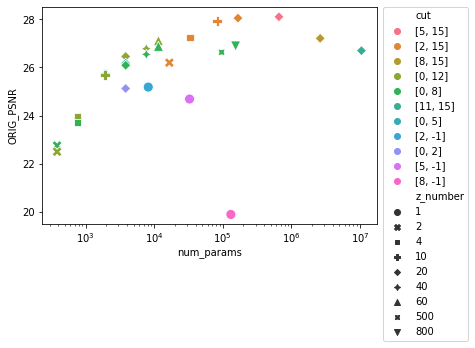

In [36]:
x = grouped_df['num_params']
y = grouped_df['ORIG_PSNR']


g = sns.scatterplot(x='num_params', y='ORIG_PSNR', hue='cut', style='z_number', data=grouped_df, s=100)
g.set(xscale='log')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);